<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: COVID-19 mRNA Vaccine Degradation Prediction

# Part 1

# Problem Statement
The goal of this project is to build a model which will predict the degradation rates at each base (A, C, G or U) of an RNA molecule which can be useful to develop models and design rules for RNA degradation to accelerate mRNA vaccine research and deliver a refrigerator-stable vaccine against SARS-CoV-2, the virus behind COVID-19.

# Background

mRNA vaccines have taken the lead as the fastest vaccine candidates for COVID-19, but currently, they face key potential limitations. One of the biggest challenges right now is how to design super stable messenger RNA molecules (mRNA). Conventional vaccines (like your seasonal flu shots) are packaged in disposable syringes and shipped under refrigeration around the world, but that is not currently possible for mRNA vaccines.

Researchers have observed that RNA molecules have the tendency to spontaneously degrade. This is a serious limitation--a single cut can render the mRNA vaccine useless. Currently, little is known on the details of where in the backbone of a given RNA is most prone to being affected. Without this knowledge, current mRNA vaccines against COVID-19 must be prepared and shipped under intense refrigeration, and are unlikely to reach more than a tiny fraction of human beings on the planet unless they can be stabilized.

Stanford’s School of Medicine are looking to leverage the data science expertise of the Kaggle community to develop models and design rules for RNA degradation.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#the basics
from matplotlib import pyplot as plt
from tqdm import tqdm
from functools import reduce
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import linear_model
import pandas as pd, numpy as np
import math, json, gc, random, os, sys
import seaborn as sns

# Dataset 
- Data souce: [Kaggle competition OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction](https://www.kaggle.com/competitions/stanford-covid-vaccine/data)
- The sequence data include two files for training and testing
- The training file contains 19 fields, and the test file contains 6 fields
- In train dataset, there are total 2400 rows of data. The sequence length is 107 characters each, but only 68 bases are measured.
- In test dataset, there are total 3634 rows of data. The sequence length contain 107 and 130 characters. 629 out of 3634 rows of data are seqence length with 107. The rest of 3005 data have sequence length of 130. For 130 sequence length, only 91 bases are measured.

## Train Dataset

In [2]:
train = pd.read_json('./stanford-covid-vaccine/train.json', lines=True).drop('index',axis=1)
train.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [3]:
print(train.shape)
print(train.info())

(2400, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2400 non-null   object 
 1   sequence             2400 non-null   object 
 2   structure            2400 non-null   object 
 3   predicted_loop_type  2400 non-null   object 
 4   signal_to_noise      2400 non-null   float64
 5   SN_filter            2400 non-null   int64  
 6   seq_length           2400 non-null   int64  
 7   seq_scored           2400 non-null   int64  
 8   reactivity_error     2400 non-null   object 
 9   deg_error_Mg_pH10    2400 non-null   object 
 10  deg_error_pH10       2400 non-null   object 
 11  deg_error_Mg_50C     2400 non-null   object 
 12  deg_error_50C        2400 non-null   object 
 13  reactivity           2400 non-null   object 
 14  deg_Mg_pH10          2400 non-null   object 
 15  deg_pH10             2400 n

In [4]:
#convert to list
train_structures = reduce(lambda x, y: x + y, train['structure'].apply(list).tolist())
train_sequences = reduce(lambda x, y: x + y, train['sequence'].apply(list).tolist())
train_predicted_loop_types = reduce(lambda x, y: x + y, train['predicted_loop_type'].apply(list).tolist())

In [5]:
print(len(train_structures))
print(len(train_sequences))
print(len(train_predicted_loop_types))

256800
256800
256800


In [6]:
# Checking missing value
if ~ train.isnull().values.any(): print('No missing values')

No missing values


## Train EDA

### Visualizing Distribution of Structure Molecules, Sequences and Predicted Loop Type

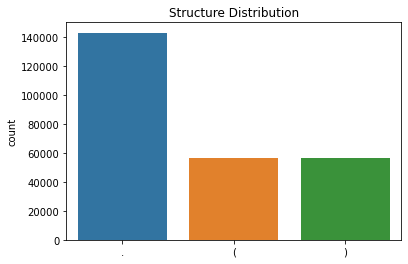

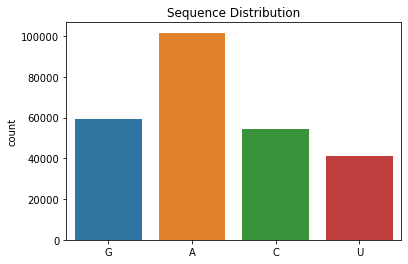

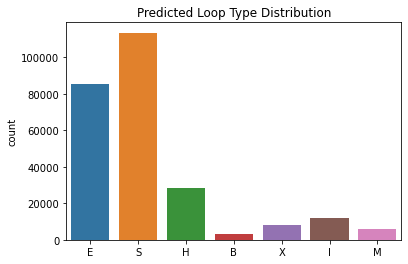

In [7]:
#plot
plt.title('Structure Distribution')
sns.countplot(train_structures)
plt.show()

plt.title('Sequence Distribution')
sns.countplot(train_sequences)
plt.show()

plt.title('Predicted Loop Type Distribution')
sns.countplot(train_predicted_loop_types)
plt.show()

#### Signal to noise distribution

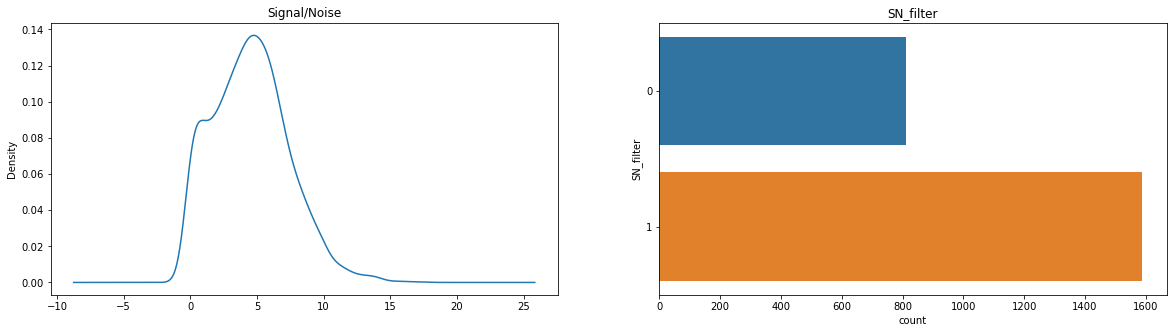

In [8]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

train['signal_to_noise'].plot.kde(ax=ax[0])
ax[0].set_title('Signal/Noise')

sns.countplot(data=train,y='SN_filter',ax=ax[1])
ax[1].set_title('SN_filter')

plt.show()

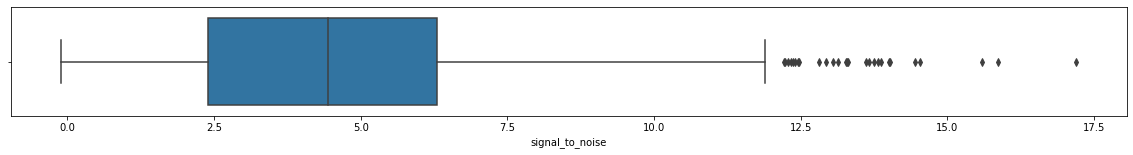

In [9]:
plt.figure(figsize=(20,2))
sns.boxplot(data=train,x='signal_to_noise')

plt.show()

- Observed negative signal-to-noise value and also very high signal-to-noise value
- Approximately 1600 RNA sequences pass the SN_filter criteria based on below condition.
    
    
SN_filter is 1 is it satisfy the below given conditions or else it is 0.
 - 1. Minimum value across all 5 conditions must be greater than -0.5.
 - 2. Mean signal/noise across all 5 conditions must be greater than 1.0.


### Targets Averaged over Positions

In [10]:
plt.style.use('fivethirtyeight')

avg_reactivity = np.array(list(map(np.array, train.reactivity))).mean(axis=0)
avg_deg_50C = np.array(list(map(np.array, train.deg_50C))).mean(axis=0)
avg_deg_pH10 = np.array(list(map(np.array, train.deg_pH10))).mean(axis=0)
avg_deg_Mg_50C = np.array(list(map(np.array, train.deg_Mg_50C))).mean(axis=0)
avg_deg_Mg_pH10 = np.array(list(map(np.array, train.deg_Mg_pH10))).mean(axis=0)

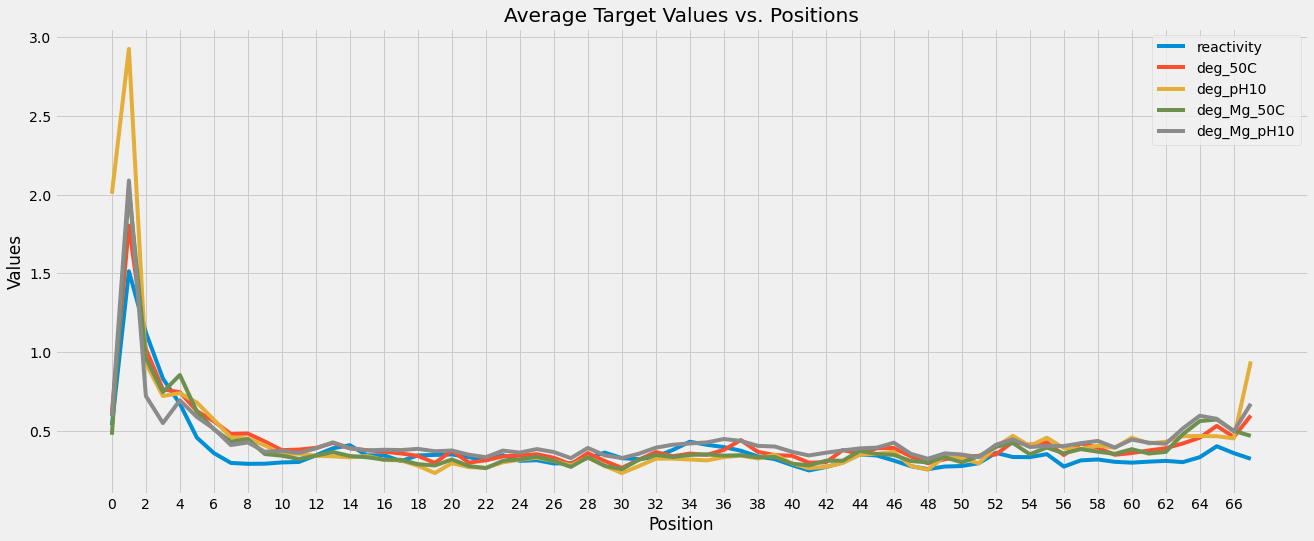

In [11]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=range(68), y=avg_reactivity, label='reactivity')
sns.lineplot(x=range(68), y=avg_deg_50C, label='deg_50C')
sns.lineplot(x=range(68), y=avg_deg_pH10, label='deg_pH10')
sns.lineplot(x=range(68), y=avg_deg_Mg_50C, label='deg_Mg_50C')
sns.lineplot(x=range(68), y=avg_deg_Mg_pH10, label='deg_Mg_pH10')

plt.xlabel('Position')
plt.xticks(range(0, 68, 2))
plt.ylabel('Values')
plt.title('Average Target Values vs. Positions')

plt.show()

- High values of Degradation & Reactivity at the beginning of the sequence
- There is high degradation because of pH10 at the beginning but no such pattern for rest of the positions.

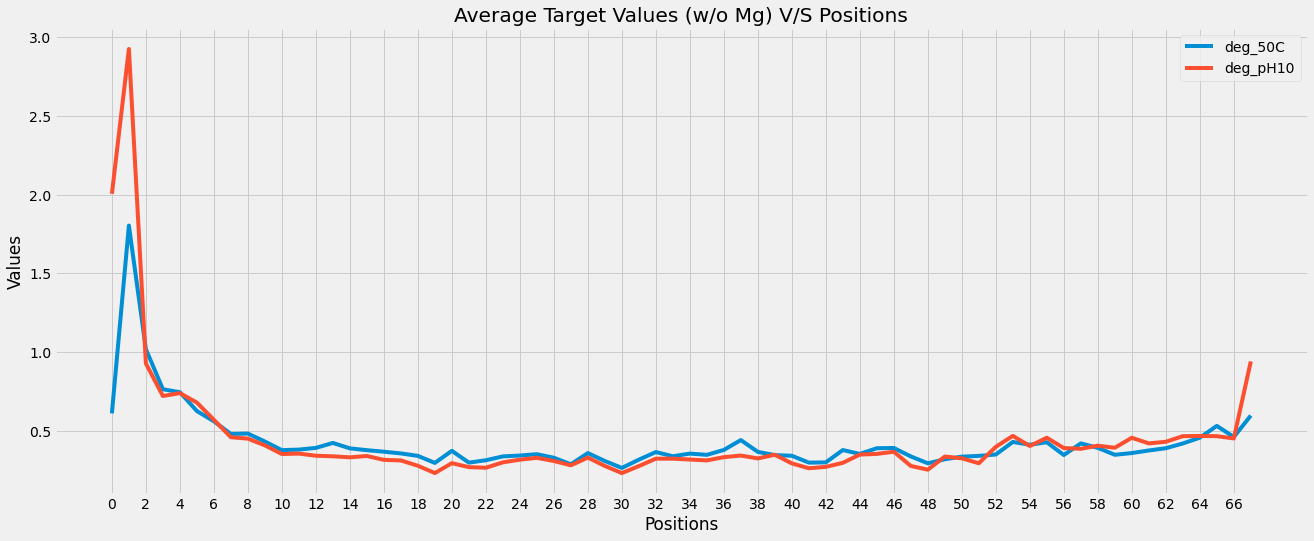

In [12]:
plt.figure(figsize=(20,8))

sns.lineplot(x=range(68),y=avg_deg_50C,label='deg_50C')
sns.lineplot(x=range(68),y=avg_deg_pH10,label='deg_pH10')

plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Values')
plt.title('Average Target Values (w/o Mg) V/S Positions')

plt.show()

- There is high degradation because of pH10 at the beginning but no such pattern for rest of the positions.
- We can see some correlation between deg_50C & deg_pH10 due to similar trend. 

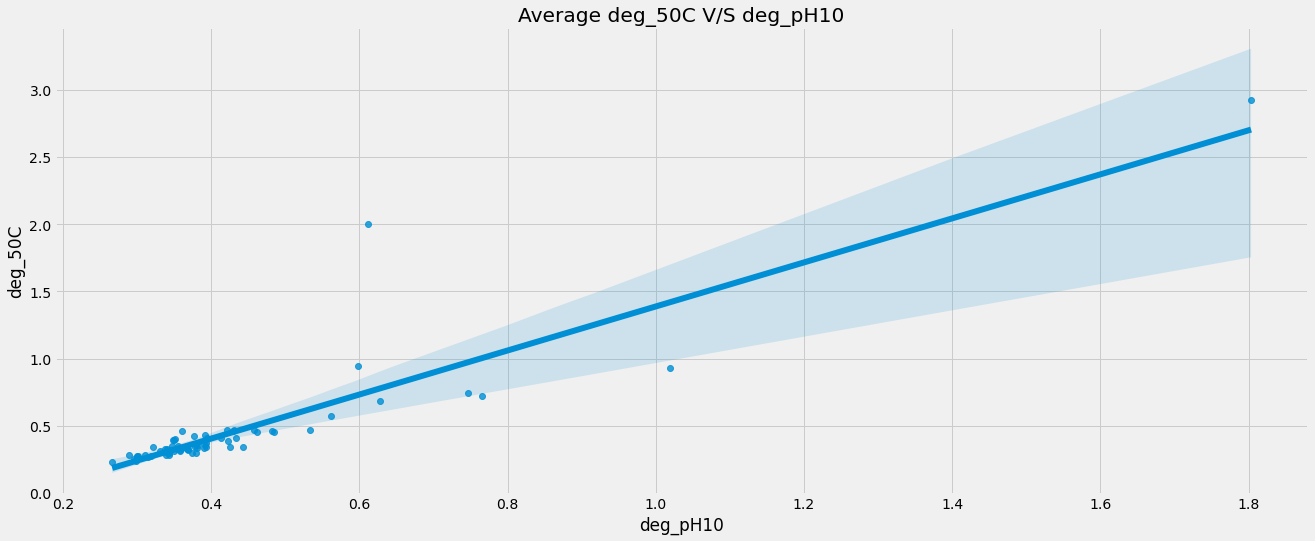

In [13]:
plt.figure(figsize=(20,8))
sns.regplot(x=avg_deg_50C,y=avg_deg_pH10)

plt.title('Average deg_50C V/S deg_pH10')
plt.ylabel('deg_50C')
plt.xlabel('deg_pH10')

plt.show()

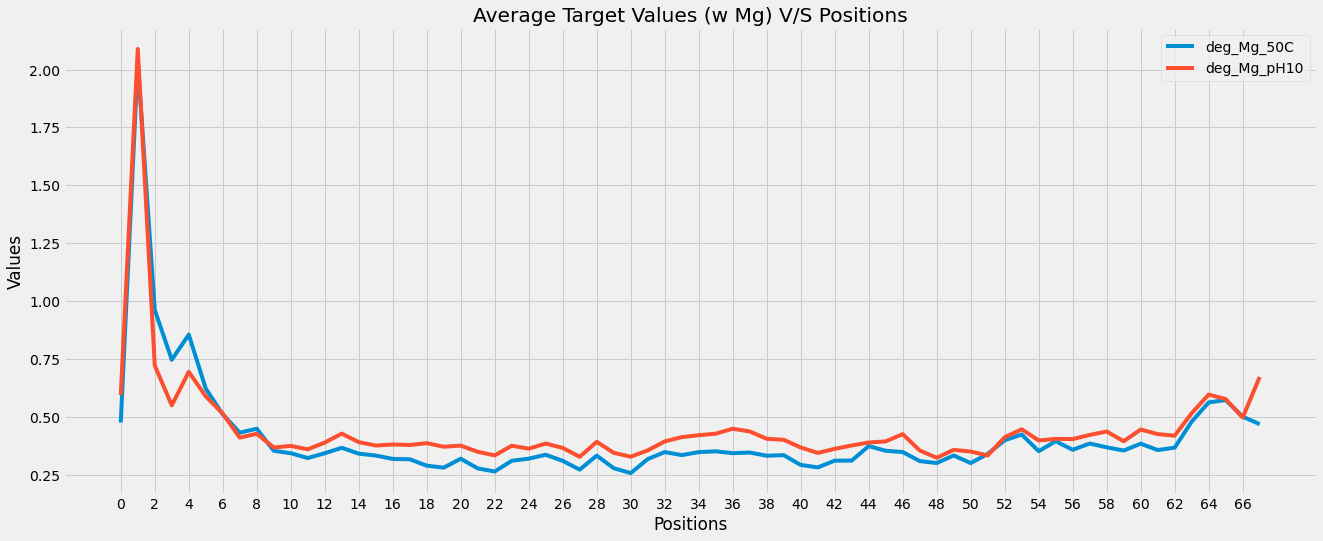

In [14]:
plt.figure(figsize=(20,8))

sns.lineplot(x=range(68),y=avg_deg_Mg_50C,label='deg_Mg_50C')
sns.lineplot(x=range(68),y=avg_deg_Mg_pH10,label='deg_Mg_pH10')

plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Values')
plt.title('Average Target Values (w Mg) V/S Positions')

plt.show()

- Most of the time deg_Mg_pH10 is more than deg_Mg_50C. We can see some correlation between them.

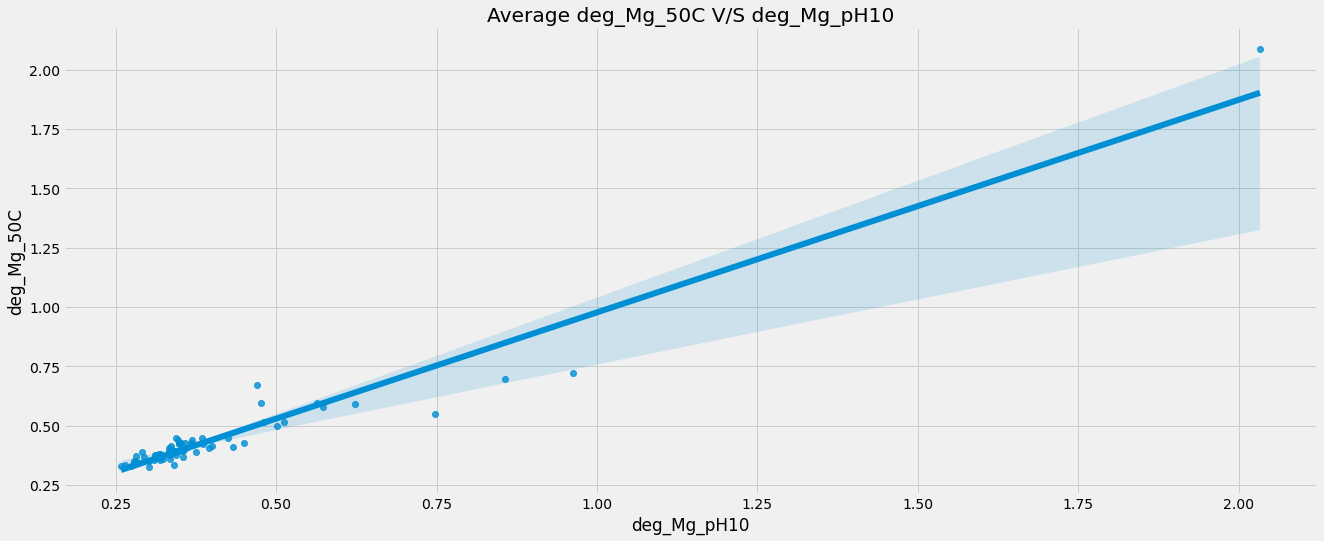

In [15]:
plt.figure(figsize=(20,8))
sns.regplot(x=avg_deg_Mg_50C,y=avg_deg_Mg_pH10)

plt.title('Average deg_Mg_50C V/S deg_Mg_pH10')
plt.ylabel('deg_Mg_50C')
plt.xlabel('deg_Mg_pH10')

plt.show()

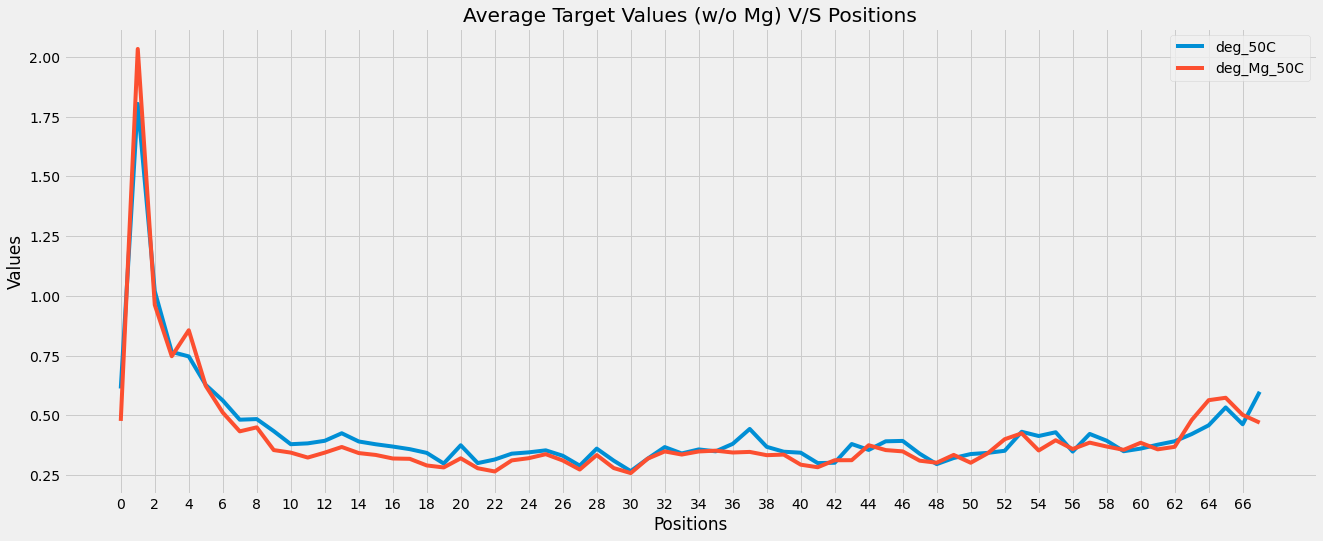

In [16]:
plt.figure(figsize=(20,8))

sns.lineplot(x=range(68),y=avg_deg_50C,label='deg_50C')
sns.lineplot(x=range(68),y=avg_deg_Mg_50C,label='deg_Mg_50C')

plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Values')
plt.title('Average Target Values (w/o Mg) V/S Positions')

plt.show()

Based on our [research](https://pubmed.ncbi.nlm.nih.gov/10333741/), Magnesium ions act in RNA stability. However, there is high degradation at the beginning of the bases. Moving down from position 6 onward, the likelihood of degradation are generally lower as compared to the bases without incubating with magnesium.

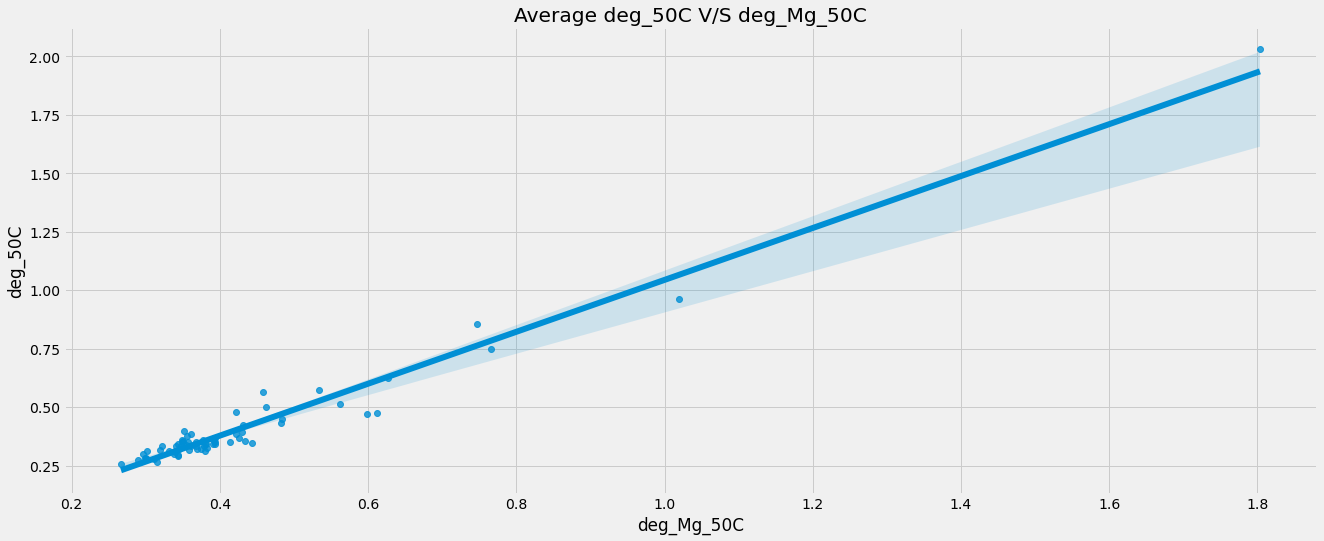

In [17]:
plt.figure(figsize=(20,8))
sns.regplot(x=avg_deg_50C,y=avg_deg_Mg_50C)

plt.title('Average deg_50C V/S deg_Mg_50C')
plt.ylabel('deg_50C')
plt.xlabel('deg_Mg_50C')

plt.show()

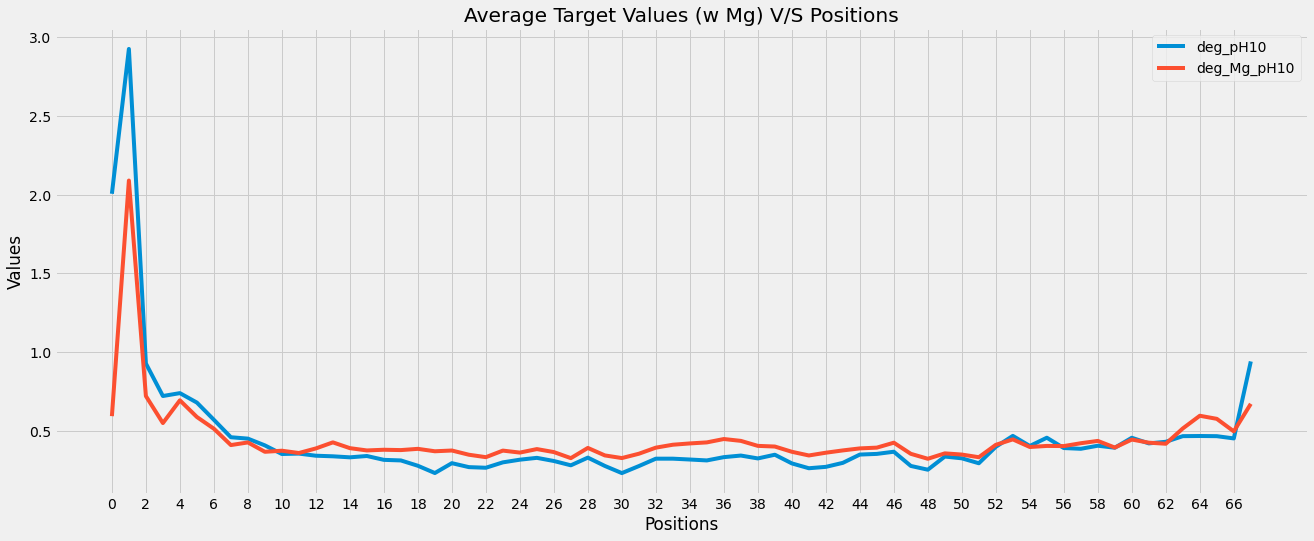

In [18]:
plt.figure(figsize=(20,8))

sns.lineplot(x=range(68),y=avg_deg_pH10,label='deg_pH10')
sns.lineplot(x=range(68),y=avg_deg_Mg_pH10,label='deg_Mg_pH10')

plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Values')
plt.title('Average Target Values (w Mg) V/S Positions')

plt.show()

With incubating with magnesium, the degradation of deg_Mg_pH10 are lower as compared to deg_pH10 for the bases position before 10. 

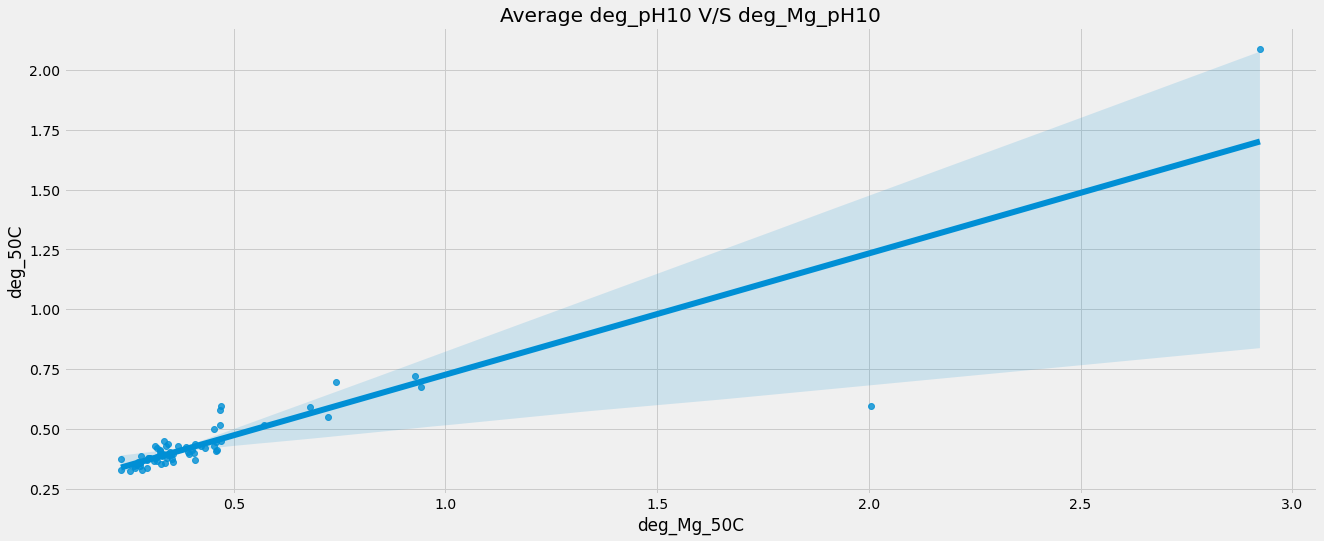

In [19]:
plt.figure(figsize=(20,8))
sns.regplot(x=avg_deg_pH10,y=avg_deg_Mg_pH10)

plt.title('Average deg_pH10 V/S deg_Mg_pH10')
plt.ylabel('deg_50C')
plt.xlabel('deg_Mg_50C')

plt.show()

### Errors in Calculation (Averaged over positions)

In [20]:
avg_reactivity_error = np.array(list(map(np.array, train.reactivity_error))).mean(axis=0)
avg_deg_error_50C = np.array(list(map(np.array, train.deg_error_50C))).mean(axis=0)
avg_deg_error_pH10 = np.array(list(map(np.array, train.deg_error_pH10))).mean(axis=0)
avg_deg_error_Mg_50C = np.array(list(map(np.array, train.deg_error_Mg_50C))).mean(axis=0)
avg_deg_error_Mg_pH10 = np.array(list(map(np.array, train.deg_error_Mg_pH10))).mean(axis=0)

data = [avg_reactivity_error, avg_deg_error_50C, avg_deg_error_pH10, avg_deg_error_Mg_50C, avg_deg_error_Mg_pH10]

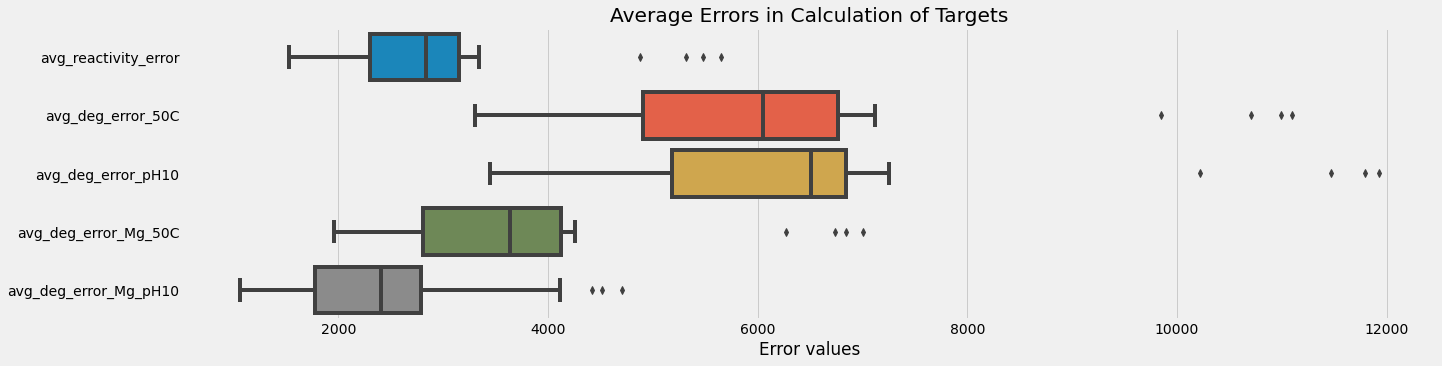

In [21]:
fig, ax = plt.subplots(figsize=(20, 5)) 

sns.boxplot(data=data,orient='h')
ax.set_yticklabels(['avg_reactivity_error', 'avg_deg_error_50C',
                    'avg_deg_error_pH10', 'avg_deg_error_Mg_50C', 'avg_deg_error_Mg_pH10'])
plt.xlabel('Error values')
plt.title('Average Errors in Calculation of Targets')
 
# show plot
plt.show()

- Very high values of Errors in deg_error_pH10 & deg_error_50C but maybe we should not worry about these targets because evaluation is not based on these targets
- Maybe this could be a reason why our models will not be scored on these two target

In [22]:
y = ['reactivity_error','deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C','deg_error_50C']
x = [np.array(list(map(np.array,train[col]))).mean(axis=0) for col in y]

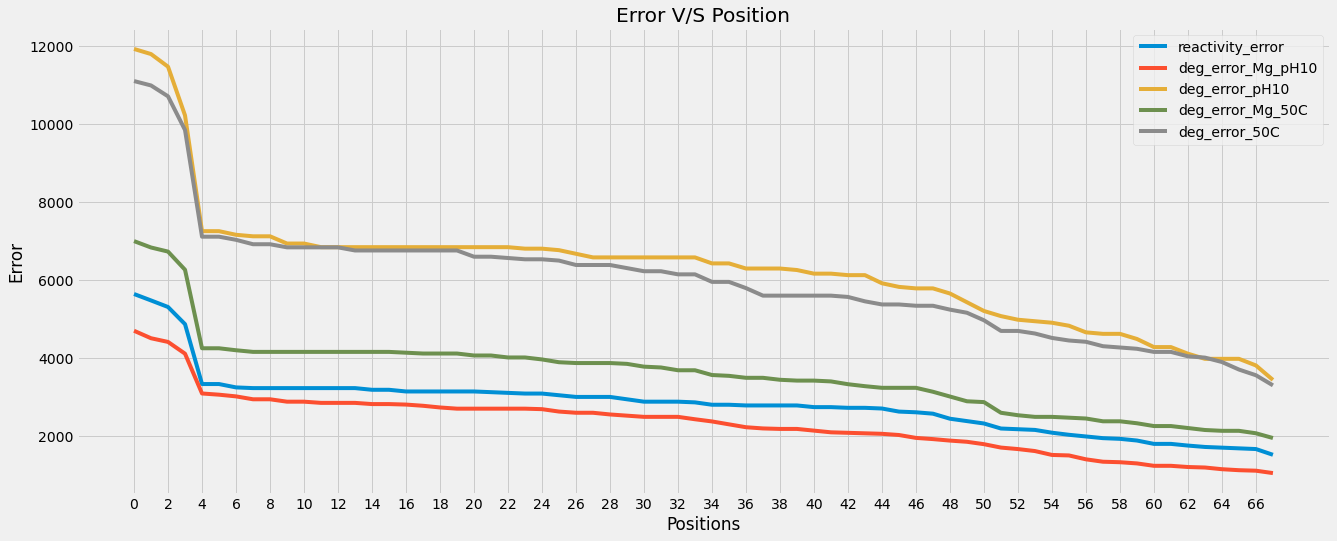

In [23]:

plt.figure(figsize=(20,8))

for i in range(len(y)):
    sns.lineplot(x=range(68),y=x[i],label=y[i])
    
plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Error')
plt.title('Error V/S Position')

plt.show()

- We can see an interesting pattern here. We have high values of errors between postions 0 and 4, but then it starts decreasing constantly as we go ahead

### Reactivity

#### Checking length of the sequence string the number of elements in the feature of reactivity

In [24]:
def length(feature):
    column= train[[feature]]
    column['length']= column[feature].apply(len)
    return column.head()

length('sequence')

,sequence,length
0,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,107
1,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,107
2,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,107
3,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,107
4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,107


In [25]:
length('reactivity')

,reactivity,length
0,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...",68
1,"[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....",68
2,"[0.44820000000000004, 1.4822, 1.1819, 0.743400...",68
3,"[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",68
4,"[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...",68


Just the 68 first letters of this string are used in this study. The corresponding features have arrays of 68 elements that match with the first 68 ltters of the sequence string.

In [26]:
train_data = []
for mol_id in train['id'].unique():
    sample_data = train.loc[train['id'] == mol_id]
    for i in range(68):
        sample_tuple = (sample_data['id'].values[0], sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], sample_data['predicted_loop_type'].values[0][i],
                        sample_data['reactivity'].values[0][i], sample_data['reactivity_error'].values[0][i],
                        sample_data['deg_Mg_pH10'].values[0][i], sample_data['deg_error_Mg_pH10'].values[0][i],
                        sample_data['deg_pH10'].values[0][i], sample_data['deg_error_pH10'].values[0][i],
                        sample_data['deg_Mg_50C'].values[0][i], sample_data['deg_error_Mg_50C'].values[0][i],
                        sample_data['deg_50C'].values[0][i], sample_data['deg_error_50C'].values[0][i])
        train_data.append(sample_tuple)

In [27]:
train_flatten = pd.DataFrame(train_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type', 'reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10',
                                  'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C'])
train_flatten.head()

,id,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
0,id_001f94081,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,0.2631,0.3581,0.1501,0.6382,0.2167
1,id_001f94081,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,0.2860,2.9683,0.2750,3.4773,0.3475
2,id_001f94081,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,0.0964,0.2589,0.0947,0.9988,0.1880
3,id_001f94081,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,0.1574,1.4552,0.1866,1.3228,0.2124
4,id_001f94081,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,0.1000,0.7244,0.1369,0.7877,0.1703


In [28]:
def plot_degradation(f1,f2):
    plt.style.use('seaborn')
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,5))
    #1 rows 2 cols
    #first row, first col
    ax1 = plt.subplot2grid((1,2),(0,0))
    plt.hist(train_flatten[f1], bins=4, color='black',alpha=0.5)
    plt.title(f'{f1}',weight='bold', fontsize=18)
    #first row sec col
    ax1 = plt.subplot2grid((1,2),(0,1))
    plt.hist(train_flatten[f2], bins=4, color='crimson',alpha=0.5)
    plt.title(f'{f2}',weight='bold', fontsize=18)
 
    plt.show()

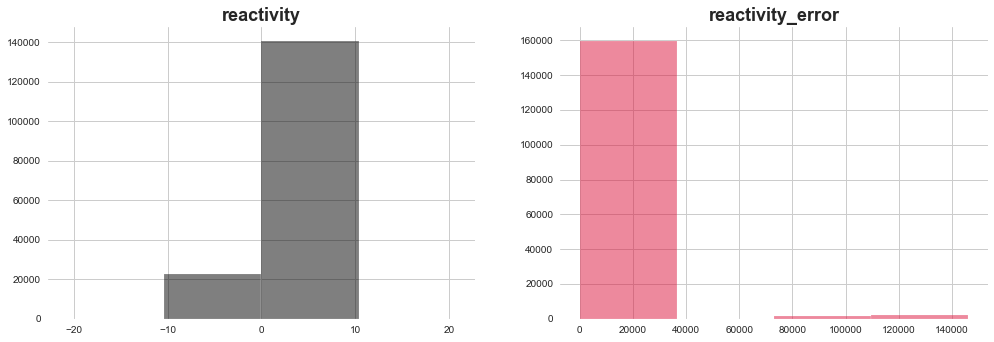

In [29]:
plot_degradation('reactivity', 'reactivity_error')

- Reactivity values are in the range (-10,10)
- Reactivity error has outliers. But error rate would not be passed during modelling so not to worry about removing it.

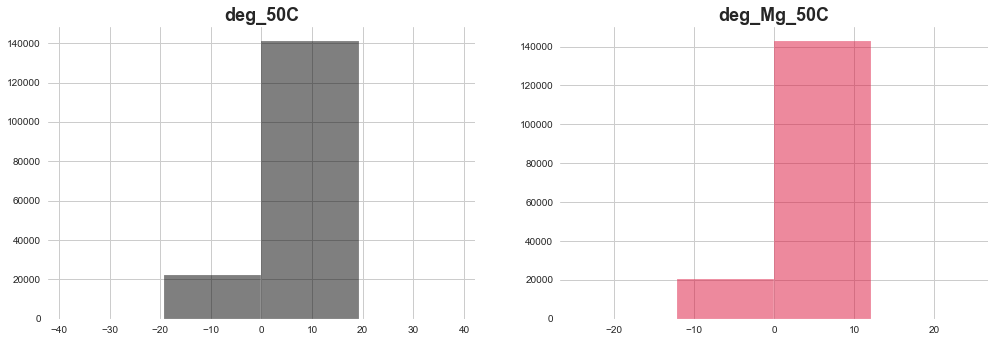

In [30]:
plot_degradation('deg_50C','deg_Mg_50C')

- deg_Mg_50C values are in the range (-12,12).
- deg_50C values are in the range (-19,19).

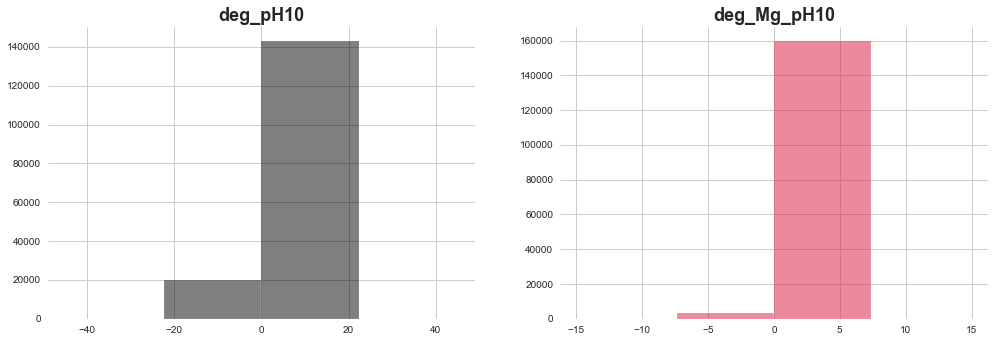

In [31]:
plot_degradation('deg_pH10','deg_Mg_pH10')

- deg_pH10 values are in the range (-20,20)
- deg_Mg_pH10 values are in the range (-7,7)

### Predicted loop type and structure

In [32]:
def plot_structure(f1,f2):
    plt.style.use('seaborn')
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,5))
    #1 rows 2 cols
    #first row, first col
    ax1 = plt.subplot2grid((1,2),(0,0))
    plt.hist(train_flatten[f1], bins=7, color='black',alpha=0.7)
    plt.title(f'{f1}',weight='bold', fontsize=18)
    #first row sec col
    ax1 = plt.subplot2grid((1,2),(0,1))
    plt.hist(train_flatten[f2], bins=5, color='crimson',alpha=0.7)
    plt.title(f'{f2}',weight='bold', fontsize=18)
    plt.xticks(weight='bold')
    plt.show()
    

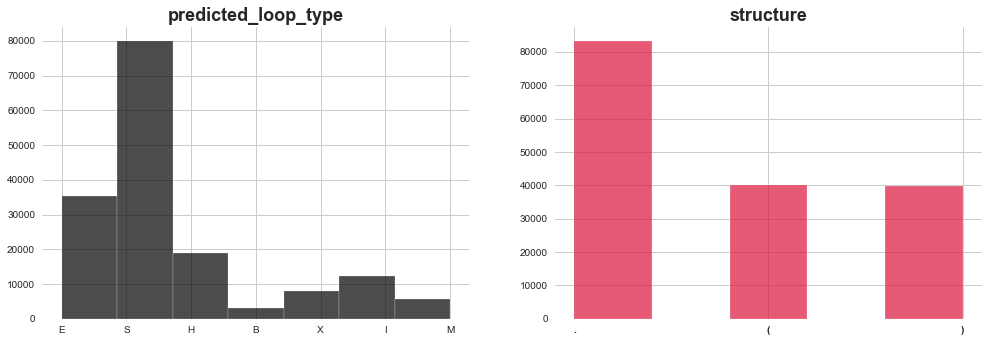

In [33]:
plot_structure('predicted_loop_type', 'structure')

- S (Paired "Stem") is the dominant loop type.
- E (Dangling End) and H (Hairpin Loop) are also highly represented in comparison with the rest
- . structure (unpaired) is dominating, the paired structures ) and ( are equally represented (sicne their pair together).

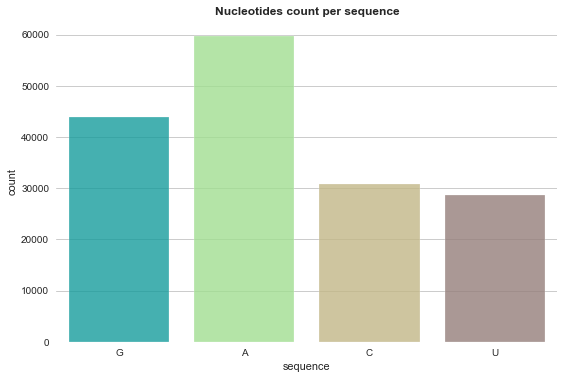

In [34]:
sns.countplot(train_flatten['sequence'], palette='terrain', alpha=0.8)
plt.title('Nucleotides count per sequence', weight='bold', fontsize=12)
plt.show()

A and G nucleotides are highly present in the sequences compared to C and U.

### Correlation between features

In [35]:
def plot_correlation(data, w=15, h=9):
    plt.figure(figsize=(w,h))
    sns.heatmap(data.corr(), cmap='hot', annot=True)
    plt.title('Correlation between the features', fontsize=18, weight='bold')
    plt.xticks(weight='bold')
    plt.yticks(weight='bold')
    return plt.show()

#### Numerical features

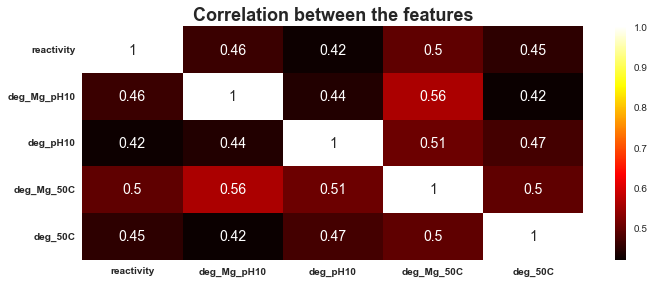

In [36]:
numeric=train_flatten[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]

plot_correlation(numeric, 10, 4)

Most correlation values are around 0.5, we can consider our variables moderately correlated.

#### Categorical variables

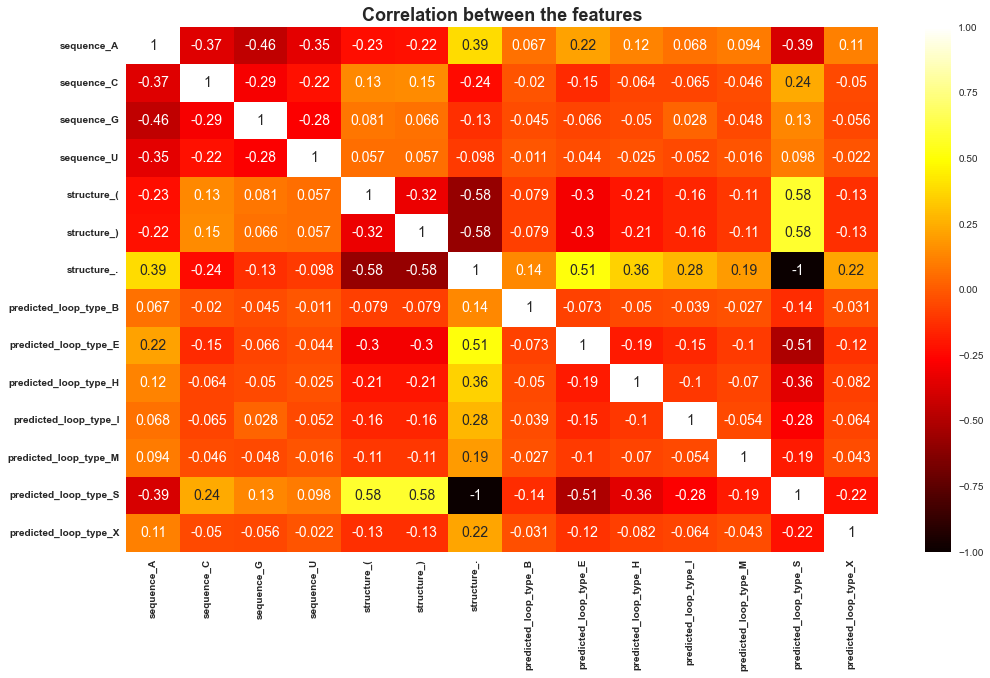

In [37]:
categorical= train_flatten[['id', 'sequence', 'structure', 'predicted_loop_type']]
categorical= pd.get_dummies(categorical, columns=['sequence', 'structure', 'predicted_loop_type'])
plot_correlation(categorical)

- The correlation between structure . and loop type S (Paired) is -1
- The correlation between structure ( and ) and loop type S is 0.58

## Test Dataset

In [38]:
test = pd.read_json('./stanford-covid-vaccine/test.json', lines=True).drop('index',axis=1)
test.head()

,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [39]:
print(test.shape)
print(test.info())

(3634, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3634 entries, 0 to 3633
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   3634 non-null   object
 1   sequence             3634 non-null   object
 2   structure            3634 non-null   object
 3   predicted_loop_type  3634 non-null   object
 4   seq_length           3634 non-null   int64 
 5   seq_scored           3634 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 170.5+ KB
None


In [40]:
#convert to list
test_structures = reduce(lambda x, y: x + y, test['structure'].apply(list).tolist())
test_sequences = reduce(lambda x, y: x + y, test['sequence'].apply(list).tolist())
test_predicted_loop_types = reduce(lambda x, y: x + y, test['predicted_loop_type'].apply(list).tolist())

In [41]:
print(len(test_structures))
print(len(test_sequences))
print(len(test_predicted_loop_types))

457953
457953
457953


In [42]:
# Checking missing value
if ~ test.isnull().values.any(): print('No missing values')

No missing values


## Test EDA

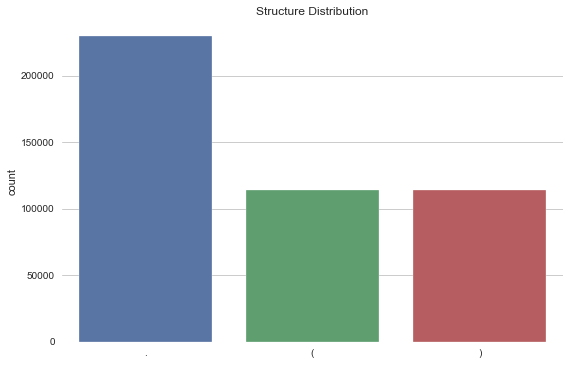

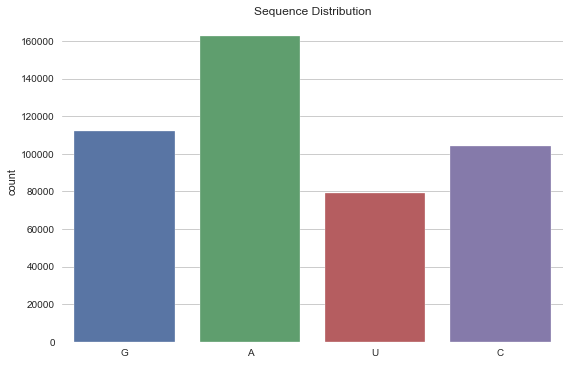

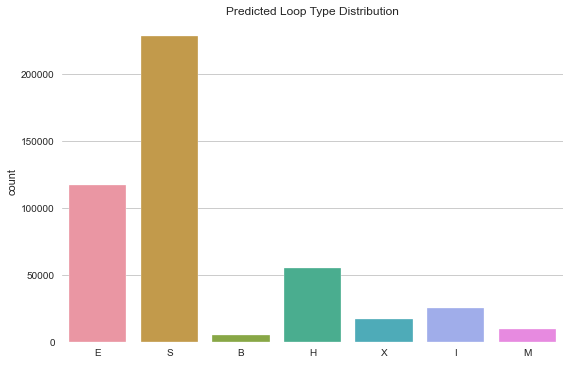

In [43]:
#plot
plt.title('Structure Distribution')
sns.countplot(test_structures)
plt.show()

plt.title('Sequence Distribution')
sns.countplot(test_sequences)
plt.show()

plt.title('Predicted Loop Type Distribution')
sns.countplot(test_predicted_loop_types)
plt.show()

# EDA Summary

- Observed negative signal-to-noise value and also very high signal-to-noise value. This is an outlier which we will remove during modelling.
- Generally, there are high values of Degradation & Reactivity (all 5 targets) at the beginning of the sequence.
- There are high values of Errors in deg_error_pH10 & deg_error_50C but maybe we should not worry about these targets because evaluation is not based on these targets.
- S (Paired "Stem") is the dominant loop type.
- E (Dangling End) and H (Hairpin Loop) are also highly represented in comparison with the rest
- . structure (unpaired) is dominating, the paired structures ) and ( are equally represented (sicne their pair together).
- A and G nucleotides are highly present in the sequences compared to C and U.
- Most correlation values (between targets) are around 0.5, we can consider our variables moderately correlated.
- The correlation between structure . and loop type S (Paired) is -1
- The correlation between structure ( and ) and loop type S is 0.58